In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


# Print available fonts
# fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# for font in fonts:
#     print(font)
# Imposta tutti i font a 12
plt.rcParams.update({'font.size': 16, 'font.family': 'Times'})
plt.rcParams['text.usetex'] = True

# Impostiamo Pandas per stampare tutte le righe e tutte le colonne
pd.set_option('display.max_rows', None)  # Mostra tutte le righe
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.width', None)  # Rimuove il limite di larghezza della visualizzazione
pd.set_option('display.max_colwidth', None)  # Mostra il contenuto completo delle celle

In [102]:
import matplotlib.dates as mdates
from math import log
import matplotlib.dates as mdates

def plot_opt_obs(scenario, df2, ax, legend_elements, y_min, y_max):
    df = df2.copy(deep=True).drop_duplicates(["timestamp","scenario_id"])  # Crea una copia profonda per evitare il SettingWithCopyWarning
    df.sort_values(by=["timestamp"], inplace=True)
    df["timestamp"] = df["timestamp"].apply(lambda x: datetime.fromtimestamp(x))


    # Crea un secondo asse Y per df["delta"] con visualizzazione a barre
    ax2 = ax.twinx()
    bar_width, offset = 0.3, 3.6
    ax2.bar(df["timestamp"] - pd.Timedelta(hours=offset), df["delta"], bar_width, label='Irrigation', color='blue', alpha=0.5)
    ax2.bar(df["timestamp"] + pd.Timedelta(hours=offset), df["daily_pluv"], bar_width, label='Pluv', color='red', alpha=0.5)
    df[df["daily_pluv"] > 20].apply(lambda dff: ax2.text(dff["timestamp"] + pd.Timedelta(hours=offset), 17, dff["daily_pluv"], color='black', ha='center'), axis=1)
    ax2.set_ylabel('Water (L)')
    ax2.tick_params(axis='y')
    ax2.set_ylim([0, 20])


    # Plot delle curve ottimali e osservate sul primo asse Y
    line1, = ax.plot(df["timestamp"], df["opt_avg"], label='Optimal', linestyle='--', color ='C8')
    line2, = ax.plot(df["timestamp"], df["obs_avg"], label='Simulated', color='C0')
    # Definisci l'intervallo sull'asse x convertendo le date in numeri
    x_start = mdates.date2num(df["timestamp"].min())  # Converte la data di inizio
    x_end = mdates.date2num(df["timestamp"].max())    # Converte la data di fine
    line4 = ax.axhline(y=log(20), label='Field Capacity', color='C9', linestyle='--')
    line5 = ax.axhline(y=log(1500), label='Permanent Wilting Point', color='C3', linestyle='--')
    # Imposta etichette e titolo per il primo asse Y
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Moisture Level')
    ax.set_title(f"{scenario}")
    ax.set_ylim([log(10), log(2000)])
    ax.tick_params(axis='y')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(df["timestamp"])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Personalizza il formato della data
    ax.set_xlim([df["timestamp"].min(), df["timestamp"].max()])

    # Aggiungi le linee alla lista della legenda se non sono già presenti
    for line in [line1, line2, line4, line5]:  #line3,
        if line.get_label() not in [elem.get_label() for elem in legend_elements]:
            legend_elements.append(line)

    # Aggiungi una "fake line" per le barre
    import matplotlib.patches as mpatches
    if 'Pluv' not in [elem.get_label() for elem in legend_elements]:
        rect = mpatches.Patch(color='red', alpha=0.5, label='Pluv')
        legend_elements.append(rect)
    if 'Irrigation' not in [elem.get_label() for elem in legend_elements]:
        rect = mpatches.Patch(color='blue', alpha=0.5, label='Irrigation')
        legend_elements.append(rect)
    # Restituisce gli elementi della legenda aggiornata
    return legend_elements

def plot_compensation_conf_result(path, soil_type):
  # Test con dati simulati
  df = pd.read_csv(path)
  scenarios = df["scenario_id"].unique()
  fig, axes = plt.subplots(3, 2, figsize=(15, 12))
  fig.suptitle(f"``{soil_type}'' with $K_P$ = {round(df['kp'][0])}, $K_I$ = {df['ki'][0]}")
  axes = axes.flatten()
  min_obs = min(df["obs_avg"])
  min_opt = min(df["opt_avg"])
  max_obs = max(df["obs_avg"])
  max_opt = max(df["opt_avg"])
  legend_elements = []
  for id, scenario in enumerate(scenarios):
      legend_elements = plot_opt_obs(scenario, df.loc[df["scenario_id"] == scenario], axes[id], legend_elements, min([min_obs, min_opt]), max([max_obs, max_opt]))

  # Aggiunge una legenda comune tra il titolo e i grafici in due righe
  fig.legend(legend_elements, [line.get_label() for line in legend_elements], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=6)  # ncol=(len(legend_elements) + 1) // 2,  # Calcola automaticamente il numero di colonne per due righe
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # Lascia spazio sufficiente per la legenda
  plt.savefig("/".join(path.split("/")[:-1]) + f"/compensation_{soil_type.replace(" ", "_")}.svg")
  plt.savefig("/".join(path.split("/")[:-1]) + f"/compensation_{soil_type.replace(" ", "_")}.pdf")
#   plt.savefig("result.svg",format="svg")
  plt.show()

def plot_automl_conf_result(path, soil_type):
  # Test con dati simulati
  df = pd.read_csv(path)
  scenarios = df["scenario_id"].unique()
  fig, axes = plt.subplots(2, 2, figsize=(12, 9))
  fig.suptitle(f"``{soil_type}'' soil with $K_P$ = {round(df['kp'][0])}, $K_I$ = {df['ki'][0]}")
  axes = axes.flatten()
  min_obs = min(df["obs_avg"])
  min_opt = min(df["opt_avg"])
  max_obs = max(df["obs_avg"])
  max_opt = max(df["opt_avg"])
  legend_elements = []
  for id, scenario in enumerate(scenarios):
      legend_elements = plot_opt_obs(scenario, df.loc[df["scenario_id"] == scenario], axes[id], legend_elements, min([min_obs, min_opt]), max([max_obs, max_opt]))

  # Aggiunge una legenda comune tra il titolo e i grafici in due righe
  fig.legend(legend_elements, [line.get_label() for line in legend_elements], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=6)  # ncol=(len(legend_elements) + 1) // 2,  # Calcola automaticamente il numero di colonne per due righe
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # Lascia spazio sufficiente per la legenda
  plt.savefig(f"/home/results/tuning_{soil_type}.svg")
  plt.savefig(f"/home/results/tuning_{soil_type}.pdf")
#   plt.savefig("result.svg",format="svg")
  plt.show()

def plot_water_content_stats(paths, titles):
    # Verifica che i paths e i titoli siano tre
    if len(paths) != len(titles):
        raise ValueError("Need same numbero of paths and titles")

    # Crea una figura con tre subplot affiancati
    fig, axes = plt.subplots(1, len(paths), figsize=(18, 6))
    # Cicla su ciascun path, titolo e asse
    for path, title, ax in zip(paths, titles, axes):
        # Carica il DataFrame
        df = pd.read_csv(path)

        # Riformatta il DataFrame per la visualizzazione
        melted = df.melt(
            col_level=0, 
            id_vars=['timestamp'], 
            value_vars=[x for x in df.columns if x != 'timestamp']
        )

        # Plot per ciascuna variabile
        for v in melted["variable"].unique():
            f = melted[melted["variable"] == v]
            ax.plot(f["timestamp"], f["value"], label=v)

        # Imposta il titolo per il grafico corrente
        ax.set_title(title)
        # ax.legend()
        #Öax.set_ylim([-900, 0])
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Water Potential")
        ax.tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse X

    # Ottimizza il layout della figura
    fig.tight_layout()
    plt.savefig(f"results_{title.split(" ")[0]}.svg", format="svg")
    plt.show()

def plot_log_water_content_stats(paths, titles):
    # Verifica che i paths e i titoli siano tre
    if len(paths) != len(titles):
        raise ValueError("Need same numbero of paths and titles")

    # Crea una figura con tre subplot affiancati
    fig, axes = plt.subplots(1, len(paths), figsize=(18, 6))
    # Cicla su ciascun path, titolo e asse
    for path, title, ax in zip(paths, titles, axes):
        # Carica il DataFrame
        df = pd.read_csv(path)

        # Riformatta il DataFrame per la visualizzazione
        melted = df.melt(
            col_level=0, 
            id_vars=['timestamp'], 
            value_vars=[x for x in df.columns if x != 'timestamp']
        )

        # Plot per ciascuna variabile
        for v in melted["variable"].unique():
            f = melted[melted["variable"] == v]
            ax.plot(f["timestamp"], f["value"].apply(lambda x : log(abs(x))), label=v)

        # Imposta il titolo per il grafico corrente
        ax.set_title(title)
        # ax.legend()
        #Öax.set_ylim([-900, 0])
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("ln(Water Potential)")
        ax.tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse X

    # Ottimizza il layout della figura
    fig.tight_layout()
    plt.savefig(f"/home/tuning_{title.split(' ')[0]}.svg", format="svg")
    plt.show()

def parse_float(value):
    if isinstance(value, float) and value.is_integer():
        return int(value)
    return value

# Clay-Loam Results

Worst_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
36   1227.663758  success  0.317247      21.504715       28.74162
Best_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
58   1239.948128  success  0.190819      11.895123            3.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


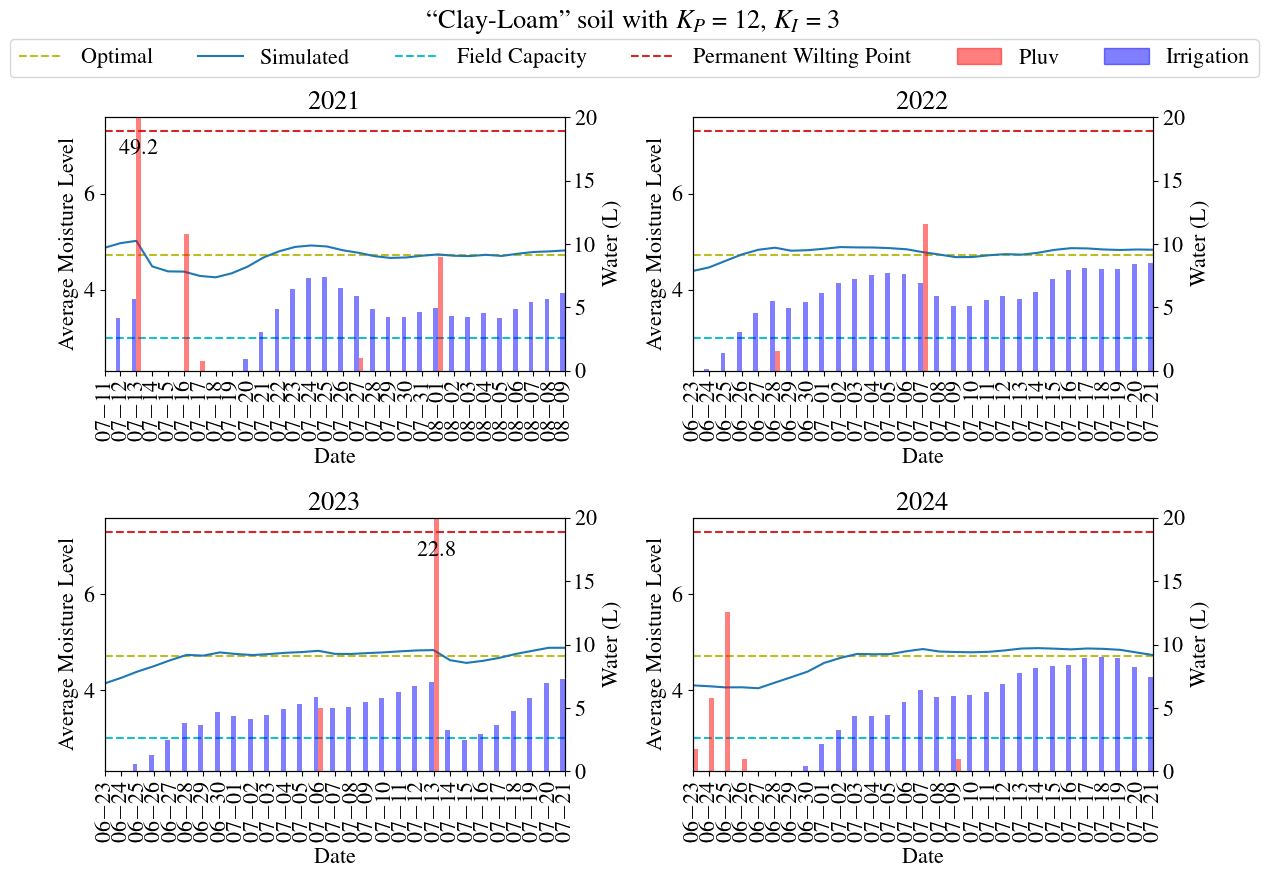

In [44]:
clay_loam = pd.read_csv("/home/tuning/errano_soil/summary/summary.csv")

print(f"Worst_scenario:\n {clay_loam.loc[clay_loam['rmse'] == max(clay_loam['rmse'])]}")
print(f"Best_scenario:\n {clay_loam.loc[clay_loam['rmse'] == min(clay_loam['rmse'])]}")

best_result_kp = clay_loam.loc[clay_loam['rmse'] == min(clay_loam['rmse']), "config__pidKP"].iloc[0]
best_result_ki = clay_loam.loc[clay_loam['rmse'] == min(clay_loam['rmse']), "config__pidKI"].iloc[0]

plot_automl_conf_result(f"/home/tuning/errano_soil/run_Kp{parse_float(best_result_kp)}_ki{parse_float(best_result_ki)}_statistics.csv", "Clay-Loam")

# Silty Loam Results

Worst_scenario:
    time_total_s   status      rmse  config__pidKP  config__pidKI
0    627.838452  success  0.344586       5.630666      20.476184
Best_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
54    666.385098  success  0.221892      10.017325            3.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


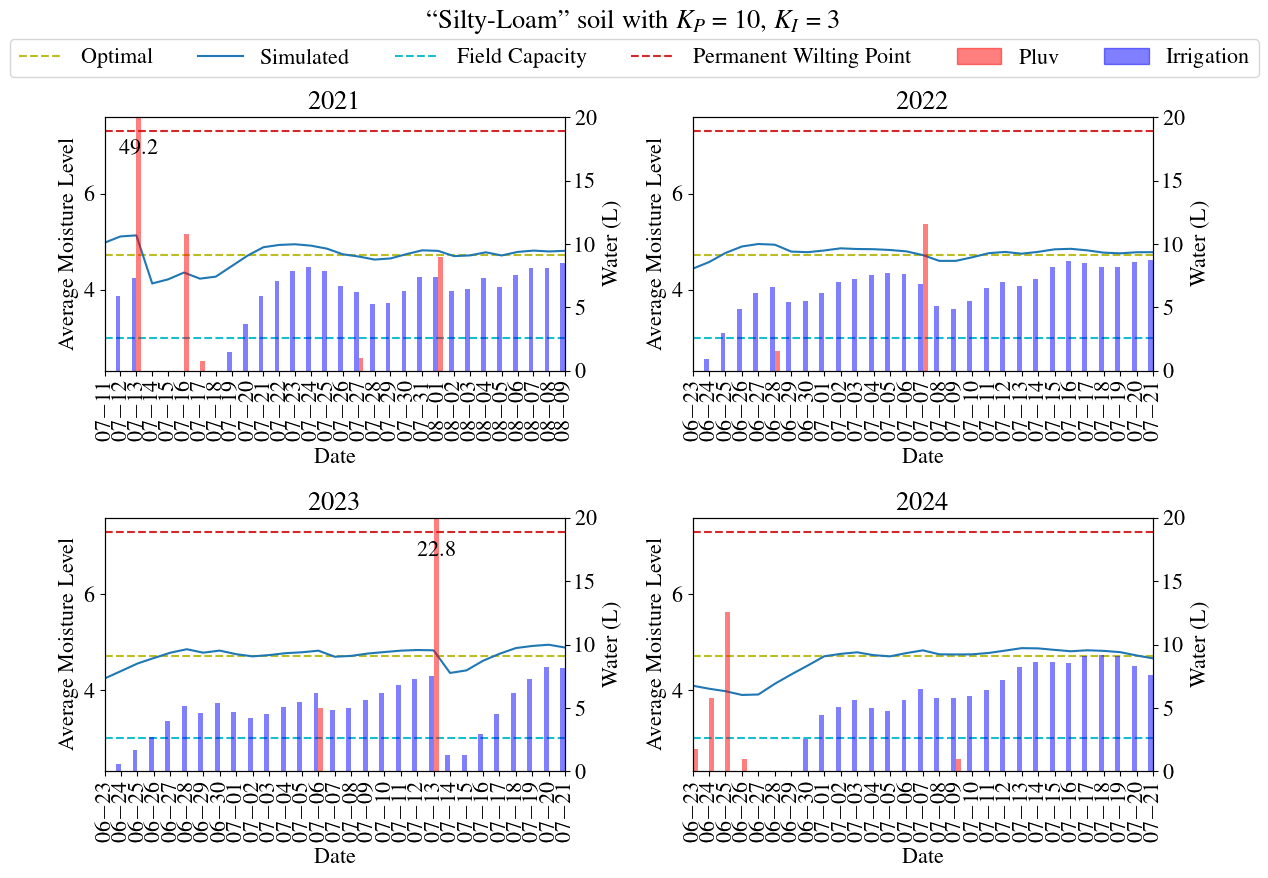

In [38]:
silty_loam = pd.read_csv("/home/tuning/silty_soil/output/summary/summary.csv")

print(f"Worst_scenario:\n {silty_loam.loc[silty_loam['rmse'] == max(silty_loam['rmse'])]}")
print(f"Best_scenario:\n {silty_loam.loc[silty_loam['rmse'] == min(silty_loam['rmse'])]}")

best_result_kp = silty_loam.loc[silty_loam['rmse'] == min(silty_loam['rmse']), "config__pidKP"].iloc[0]
best_result_ki = silty_loam.loc[silty_loam['rmse'] == min(silty_loam['rmse']), "config__pidKI"].iloc[0]

plot_automl_conf_result(f"/home/tuning/silty_soil/output/run_Kp{parse_float(best_result_kp)}_ki{parse_float(best_result_ki)}_statistics.csv", "Silty-Loam")



# Sandy-Loam results

Worst_scenario:
    time_total_s   status      rmse  config__pidKP  config__pidKI
7    977.106258  success  0.382662       8.347697      23.534329
Best_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
37   1020.901576  success  0.294957       7.482629            3.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


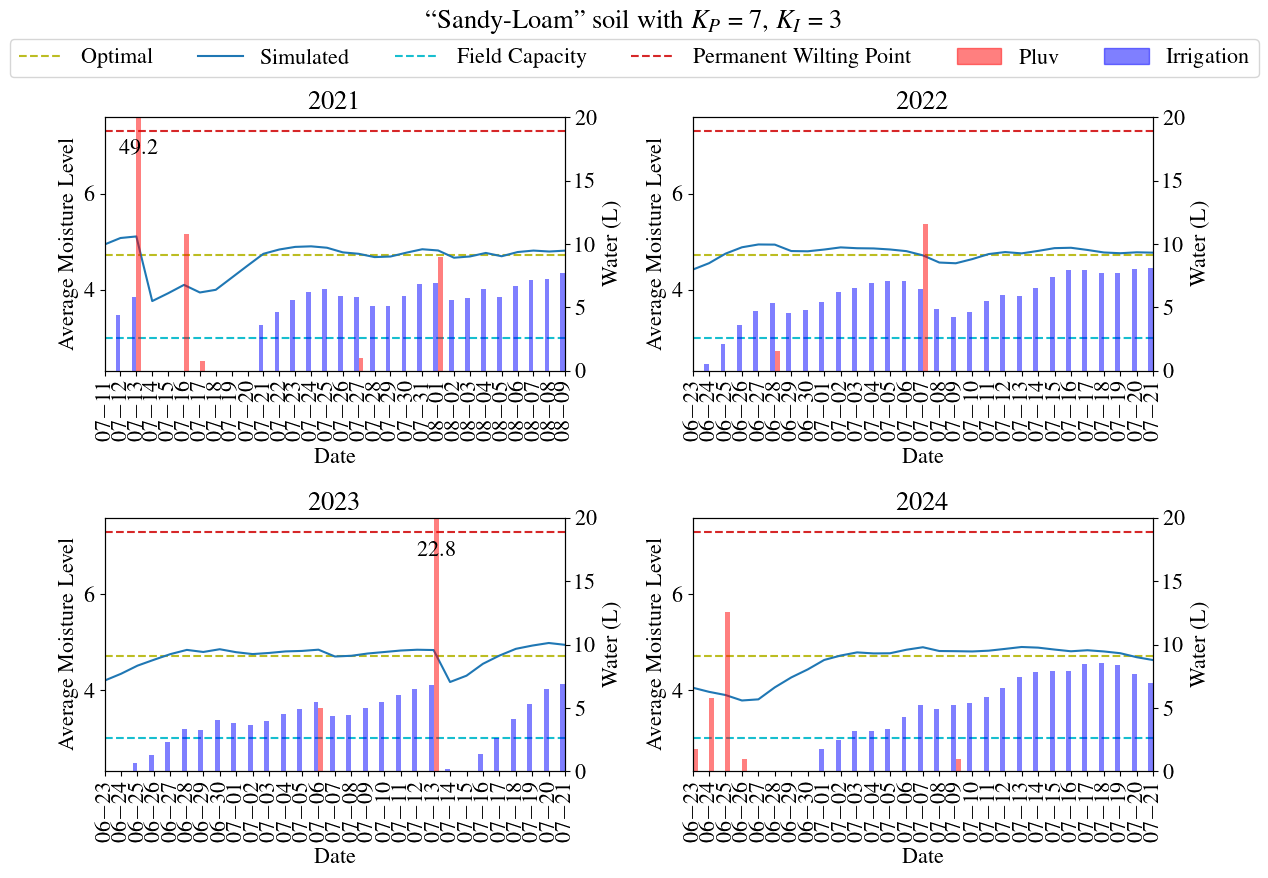

In [39]:
sandy_loam = pd.read_csv("/home/tuning/sandy_soil/summary/summary.csv")

print(f"Worst_scenario:\n {sandy_loam.loc[sandy_loam['rmse'] == max(sandy_loam['rmse'])]}")
print(f"Best_scenario:\n {sandy_loam.loc[sandy_loam['rmse'] == min(sandy_loam['rmse'])]}")

best_result_kp = sandy_loam.loc[sandy_loam['rmse'] == min(sandy_loam['rmse']), "config__pidKP"].iloc[0]
best_result_ki = sandy_loam.loc[sandy_loam['rmse'] == min(sandy_loam['rmse']), "config__pidKI"].iloc[0]

plot_automl_conf_result(f"/home/tuning/sandy_soil/run_Kp{parse_float(best_result_kp)}_ki{parse_float(best_result_ki)}_statistics.csv", "Sandy-Loam")



# PID actuation compensation tests

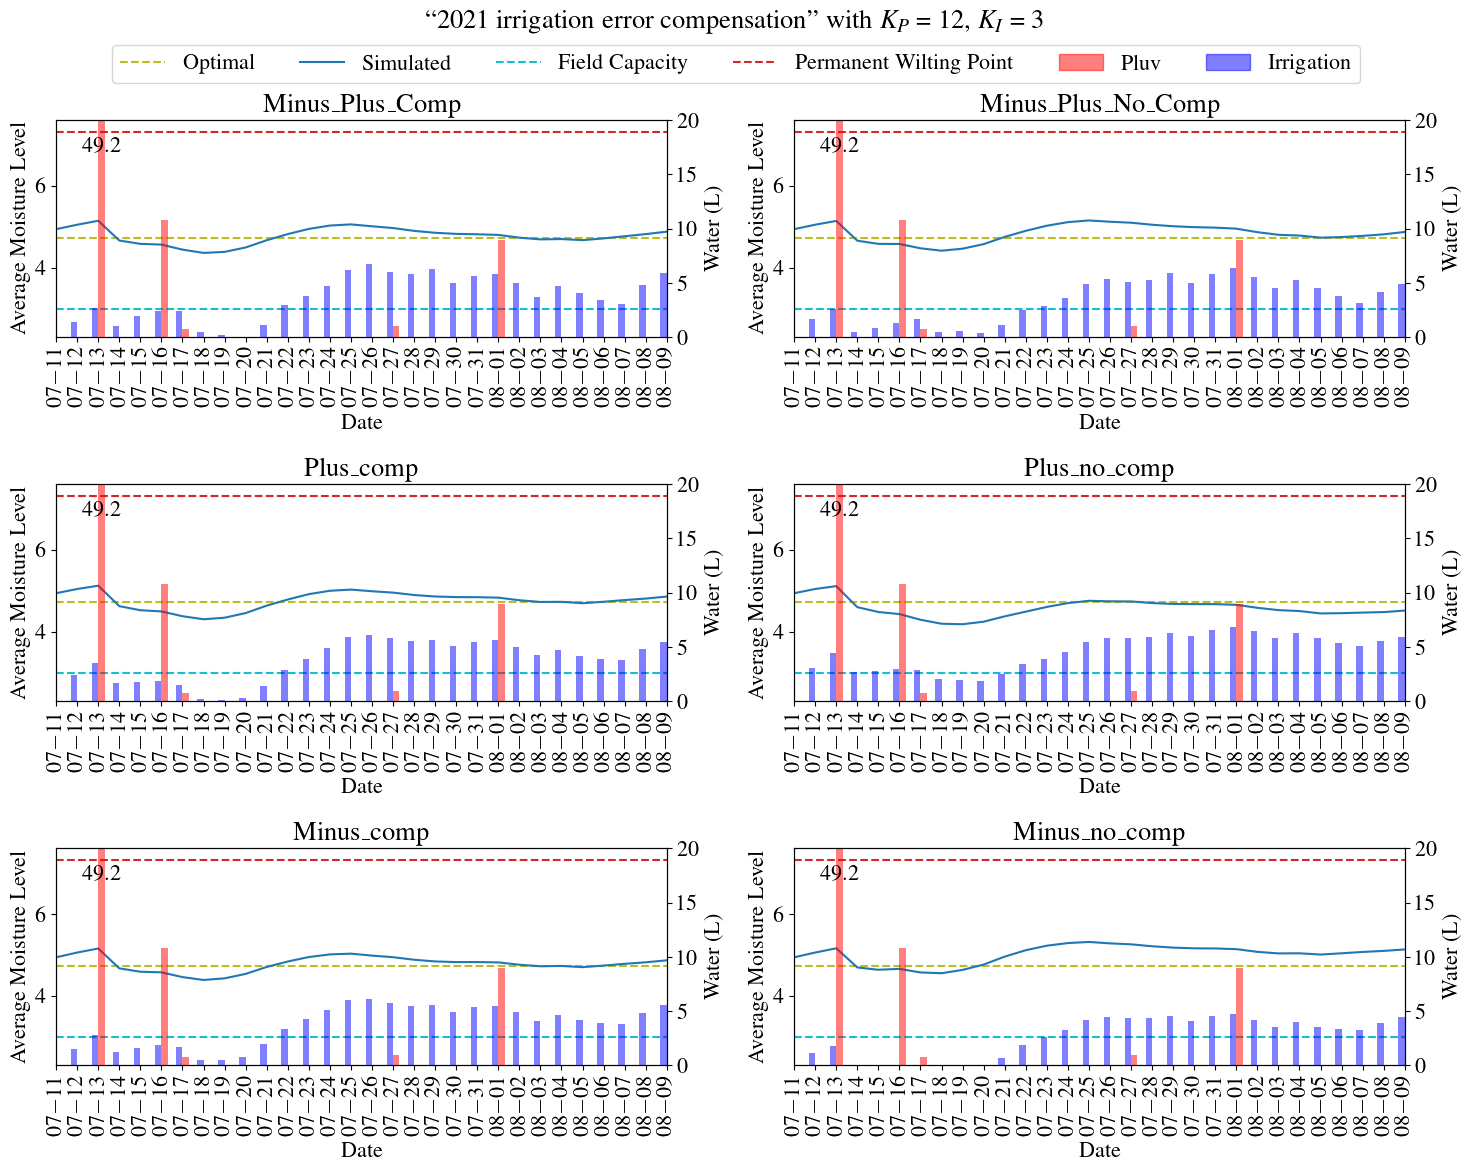

scenario_id
Minus_Plus_Comp       108.770958
Minus_Plus_No_Comp    101.375633
Minus_comp            108.651378
Minus_no_comp          75.199901
Plus_comp             109.993385
Plus_no_comp          136.063041
Name: delta, dtype: float64

In [ ]:
# minus_plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/minus_plus_comp.csv")
# plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/plus_comp.csv")
# plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/plus_no_comp.csv")
# minus_plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/minus_plus_no_comp.csv")
# minus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/minus_comp.csv")
# minus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/minus_no_comp.csv")
# df = pd.concat([minus_plus_comp,minus_plus_no_comp,plus_comp,plus_no_comp,minus_comp,minus_no_comp], ignore_index=True)
# df.to_csv("/home/tuning/pid_compensation/actual_irrigation/agg.csv",index=False)


plot_compensation_conf_result("/home/tuning/pid_compensation/actual_irrigation/2021/agg.csv", "2021 irrigation error compensation")
agg_2021 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/agg.csv")

agg_2021.groupby("scenario_id")["delta"].sum()


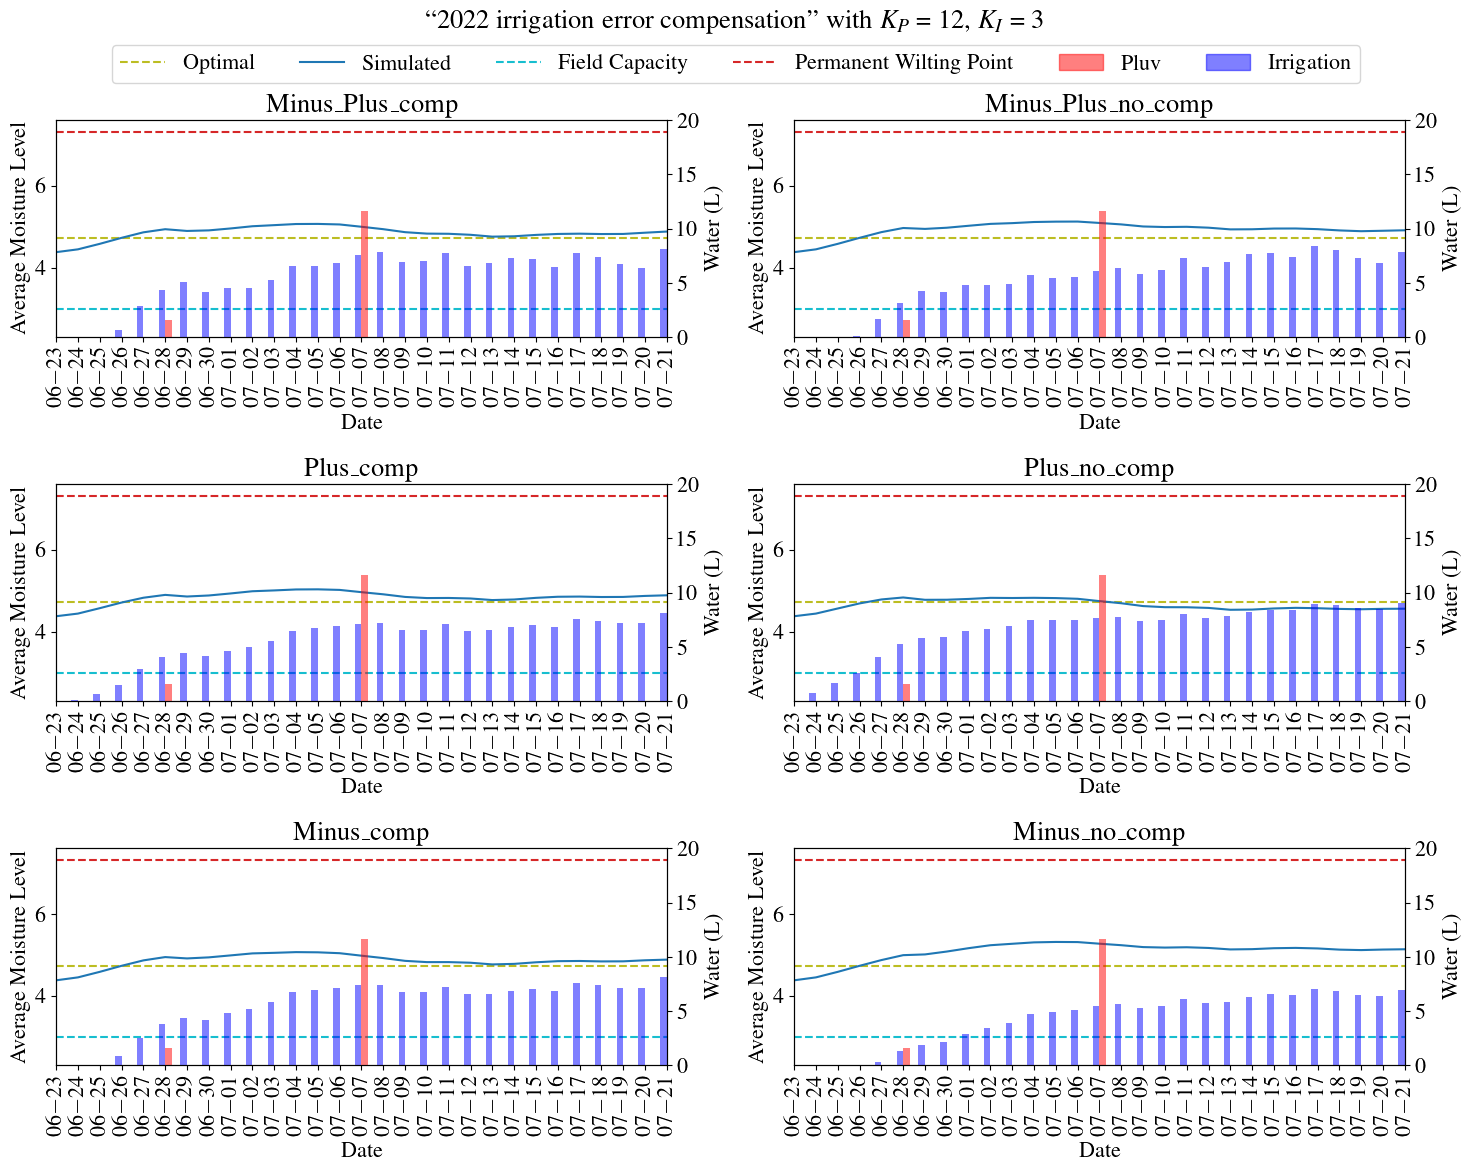

scenario_id
Minus_Plus_comp       158.690190
Minus_Plus_no_comp    150.653433
Minus_comp            158.398106
Minus_no_comp         120.604082
Plus_comp             160.133445
Plus_no_comp          192.339543
Name: delta, dtype: float64

In [ ]:
# minus_plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/minus_plus_comp.csv")
# plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/plus_comp.csv")
# plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/plus_no_comp.csv")
# minus_plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/minus_plus_no_comp.csv")
# minus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/minus_comp.csv")
# minus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/minus_no_comp.csv")

# df = pd.concat([minus_plus_comp,minus_plus_no_comp,plus_comp,plus_no_comp,minus_comp,minus_no_comp], ignore_index=True)
# df.to_csv("/home/tuning/pid_compensation/actual_irrigation/2022/agg.csv",index=False)
agg = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/agg.csv")

plot_compensation_conf_result("/home/tuning/pid_compensation/actual_irrigation/2022/agg.csv", "2022 irrigation error compensation")
agg_2022 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/agg.csv")

agg_2022.groupby("scenario_id")["delta"].sum()

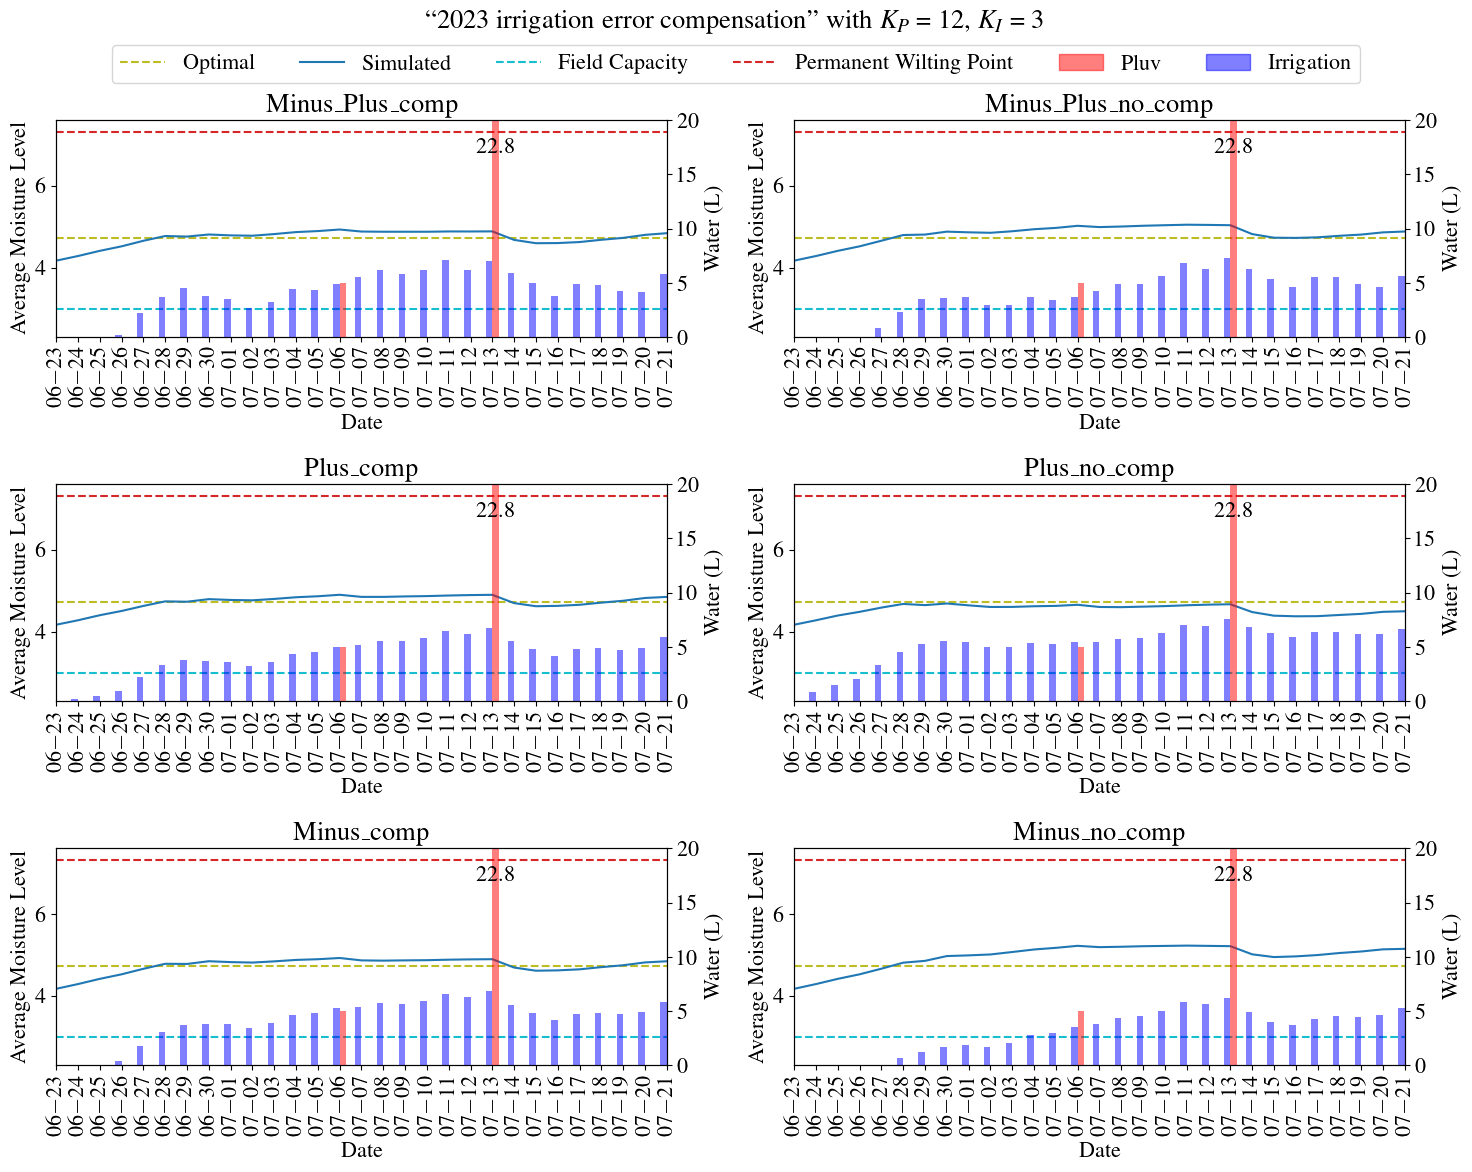

scenario_id
Minus_Plus_comp       120.009524
Minus_Plus_no_comp    112.686098
Minus_comp            119.986660
Minus_no_comp          86.905994
Plus_comp             121.369072
Plus_no_comp          150.758277
Name: delta, dtype: float64

In [110]:
# minus_plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/minus_plus_comp.csv")
# plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/plus_comp.csv")
# plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/plus_no_comp.csv")
# minus_plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/minus_plus_no_comp.csv")
# minus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/minus_comp.csv")
# minus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/minus_no_comp.csv")

# df = pd.concat([minus_plus_comp,minus_plus_no_comp,plus_comp,plus_no_comp,minus_comp,minus_no_comp], ignore_index=True)
# df.to_csv("/home/tuning/pid_compensation/actual_irrigation/2023/agg.csv",index=False)


plot_compensation_conf_result("/home/tuning/pid_compensation/actual_irrigation/2023/agg.csv", "2023 irrigation error compensation")
agg_2023 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/agg.csv")

agg_2023.groupby("scenario_id")["delta"].sum()

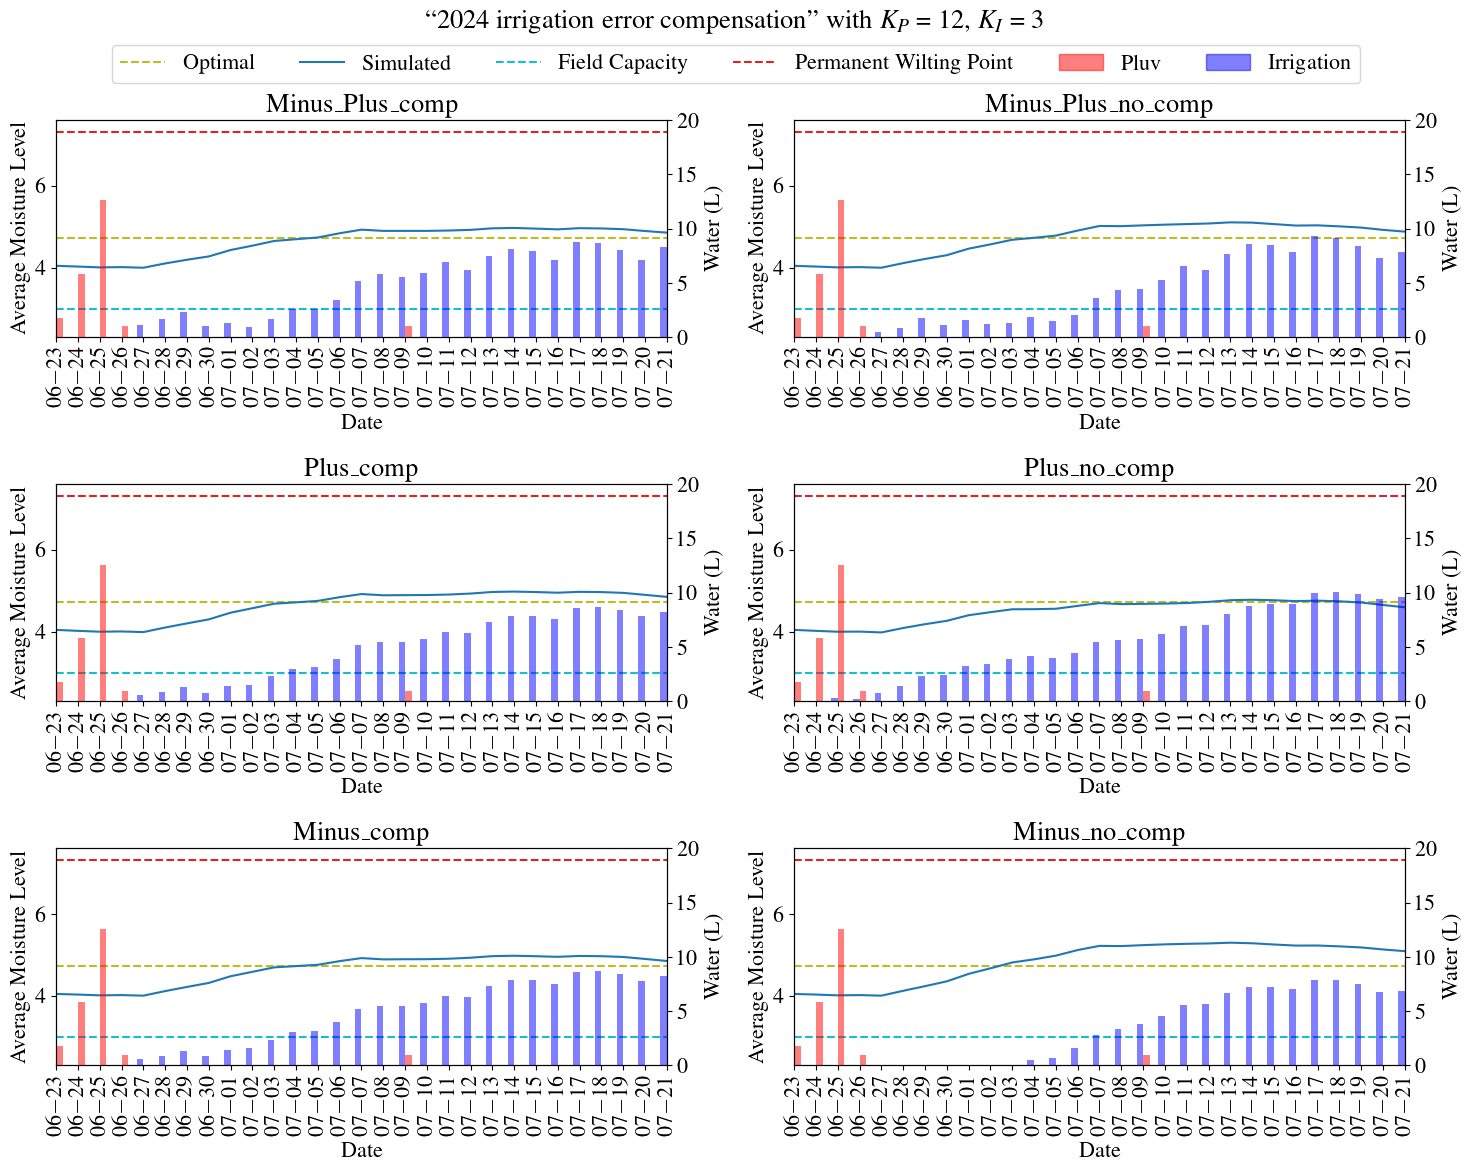

scenario_id
Minus_Plus_comp       124.542588
Minus_Plus_no_comp    117.165950
Minus_comp            125.116737
Minus_no_comp          88.756539
Plus_comp             125.569497
Plus_no_comp          152.088395
Name: delta, dtype: float64

In [111]:
# minus_plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/minus_plus_comp.csv")
# plus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/plus_comp.csv")
# plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/plus_no_comp.csv")
# minus_plus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/minus_plus_no_comp.csv")
# minus_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/minus_comp.csv")
# minus_no_comp = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/minus_no_comp.csv")

# df = pd.concat([minus_plus_comp,minus_plus_no_comp,plus_comp,plus_no_comp,minus_comp,minus_no_comp], ignore_index=True)
# df.to_csv("/home/tuning/pid_compensation/actual_irrigation/2024/agg.csv",index=False)


plot_compensation_conf_result("/home/tuning/pid_compensation/actual_irrigation/2024/agg.csv", "2024 irrigation error compensation")
agg_2024 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/agg.csv")

agg_2024.groupby("scenario_id")["delta"].sum()

# R<sup>2</sup> evaluation

In [120]:
agg_2021 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2021/agg.csv")
agg_2022 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2022/agg.csv")
agg_2023 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2023/agg.csv")
agg_2024 = pd.read_csv("/home/tuning/pid_compensation/actual_irrigation/2024/agg.csv")


r_2021 = agg_2021.groupby("scenario_id")["r"].apply(lambda x: pow(abs(x),2).mean() ** 0.5)
r_2022 = agg_2022.groupby("scenario_id")["r"].apply(lambda x: pow(abs(x),2).mean() ** 0.5)
r_2023 = agg_2023.groupby("scenario_id")["r"].apply(lambda x: pow(abs(x),2).mean() ** 0.5)
r_2024 = agg_2023.groupby("scenario_id")["r"].apply(lambda x: pow(abs(x),2).mean() ** 0.5)

rmse_df = pd.concat([
    r_2021.rename("RMSE_2021"),
    r_2022.rename("RMSE_2022"),
    r_2023.rename("RMSE_2023"),
    r_2024.rename("RMSE_2024")
], axis=1)

rmse_df["Overall_RMSE_mean"] = rmse_df.mean(axis=1)

rmse_df

,RMSE_2021,RMSE_2022,RMSE_2023,RMSE_2024,Overall_RMSE_mean
scenario_id,,,,,
Minus_Plus_comp,0.104470,0.103829,0.086736,0.086736,0.095442
Minus_Plus_no_comp,0.137689,0.141790,0.128328,0.128328,0.134033
Minus_comp,0.099826,0.106420,0.088438,0.088438,0.095780
Minus_no_comp,0.228899,0.245994,0.227094,0.227094,0.232270
Plus_comp,0.098635,0.093633,0.079548,0.079548,0.087841
Plus_no_comp,0.108947,0.086407,0.100556,0.100556,0.099116
